In [72]:
# ---------------------------------------------------------------
# Cell 1: Carga de volumen individual para inferencia
# Carga un volumen CT del dataset ATM'22 con su label manual (gold standard)
# ---------------------------------------------------------------

import os
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt

# === CONFIGURACIÓN DE RUTAS ===
DATA_PATHS = {
    "images_batch1": r"./TrainBatch1/imagesTr",
    "labels_batch1": r"./TrainBatch1/labelsTr"
}

# Parámetros de HU Clipping (deben coincidir con el pipeline de entrenamiento)
HU_MIN, HU_MAX = -1024, 600

# === SELECCIÓN DEL CASO ===
batch_key = "batch1"
images_dir = DATA_PATHS[f"images_{batch_key}"]
labels_dir = DATA_PATHS[f"labels_{batch_key}"]

# Selecciona un caso específico (puedes cambiar el índice)
image_files = sorted([f for f in os.listdir(images_dir) if f.endswith(".nii.gz")])
if not image_files:
    raise FileNotFoundError(f"No se encontraron imágenes en {images_dir}")

# Cambia el índice para probar diferentes casos (0 = primer caso)
selected_image = image_files[0]  
case_id = selected_image.replace("_0000.nii.gz", "")

# Encuentra el label correspondiente
label_files = [f for f in os.listdir(labels_dir) if f.startswith(case_id) and f.endswith(".nii.gz")]
if not label_files:
    raise FileNotFoundError(f"No se encontró label para el caso '{case_id}' en {labels_dir}")
selected_label = label_files[0]

img_path = os.path.join(images_dir, selected_image)
lbl_path = os.path.join(labels_dir, selected_label)

# === CARGA Y PREPROCESAMIENTO ===
img_nii = nib.load(img_path)
vol_orig = img_nii.get_fdata(dtype=np.float32)
affine, header = img_nii.affine, img_nii.header

lbl_nii = nib.load(lbl_path)
vol_label = lbl_nii.get_fdata().astype(np.uint8)

# Aplica HU Clipping
vol_clip = np.clip(vol_orig, HU_MIN, HU_MAX)

# === LOG DE AUDITORÍA ===
audit_log = {
    "Caso Analizado": case_id,
    "Ruta Imagen": img_path,
    "Ruta Label": lbl_path,
    "Dimensión del Volumen": vol_orig.shape,
    "Espaciado (mm)": tuple(round(s, 3) for s in header.get_zooms()),
    "HU Mín (Original)": float(vol_orig.min()),
    "HU Máx (Original)": float(vol_orig.max()),
    "HU Mín (Clipped)": float(vol_clip.min()),
    "HU Máx (Clipped)": float(vol_clip.max()),
    "Rango de Clipping": f"[{HU_MIN}, {HU_MAX}] HU"
}

print("=" * 50)
print("        LOG DE AUDITORÍA: CARGA Y CLIPPING")
print("=" * 50)
for key, value in audit_log.items():
    print(f"{key:<25}: {value}")
print("=" * 50)

# === VARIABLES GLOBALES PARA CELDAS SIGUIENTES ===
inference_vol_orig = vol_orig
inference_vol_clip = vol_clip
inference_vol_label = vol_label
inference_affine = affine
inference_header = header
inference_case_id = case_id

print(f"Volumen '{case_id}' cargado exitosamente para inferencia.")

        LOG DE AUDITORÍA: CARGA Y CLIPPING
Caso Analizado           : ATM_001
Ruta Imagen              : ./TrainBatch1/imagesTr\ATM_001_0000.nii.gz
Ruta Label               : ./TrainBatch1/labelsTr\ATM_001_0000.nii.gz
Dimensión del Volumen    : (512, 512, 679)
Espaciado (mm)           : (np.float32(0.82), np.float32(0.82), np.float32(0.5))
HU Mín (Original)        : -1024.0
HU Máx (Original)        : 3071.0
HU Mín (Clipped)         : -1024.0
HU Máx (Clipped)         : 600.0
Rango de Clipping        : [-1024, 600] HU
Volumen 'ATM_001' cargado exitosamente para inferencia.


In [73]:
# ---------------------------------------------------------------
# Cell 2: Generación de ROI clásica (como en ROI.ipynb)
# Crea una región de interés usando búsqueda multi-eje
# ---------------------------------------------------------------

import numpy as np
import matplotlib.pyplot as plt
from skimage.morphology import remove_small_objects, binary_closing, binary_dilation, ball
from skimage.segmentation import clear_border
from scipy.ndimage import label as cc_label, binary_fill_holes
from collections import deque

# === VERIFICAR VARIABLES DE CELDA ANTERIOR ===
required_vars = ['inference_vol_clip', 'inference_case_id']
missing_vars = [var for var in required_vars if var not in globals()]
if missing_vars:
    raise ValueError(f"Celda 1 no ejecutada. Faltan variables: {missing_vars}")

# === USAR VARIABLES GLOBALES ===
vol_clip = inference_vol_clip
case_id = inference_case_id

# --- Parámetros optimizados ---
AIR_THR_STRICT = -950      # Semillas muy oscuras (aire puro)
GROW_THR = -700            # Crecimiento (igual que en ROI.ipynb)
MIN_SIZE = 50              # Mínimo tamaño de objetos
SMOOTH_RADIUS = 5          # Suavizado

Z, Y, X = vol_clip.shape

# --- Paso 1: Semillas con búsqueda multi-eje ---
seeds = (vol_clip <= AIR_THR_STRICT)
seeds = clear_border(seeds)
seeds = remove_small_objects(seeds, min_size=MIN_SIZE)

# ✅ Regiones de búsqueda para cada eje
delta_z = Z // 10
delta_y = Y // 8
delta_x = X // 8

# Axial: alrededor de Z//2
axial_region = np.zeros_like(seeds, dtype=bool)
z_axial = Z // 2
axial_region[max(0, z_axial - delta_z):min(Z, z_axial + delta_z), :, :] = True

# Coronal: alrededor de Y//2
coronal_region = np.zeros_like(seeds, dtype=bool)
y_coronal = Y // 2
coronal_region[:, max(0, y_coronal - delta_y):min(Y, y_coronal + delta_y), :] = True

# Sagittal: alrededor de X//2
sagittal_region = np.zeros_like(seeds, dtype=bool)
x_sagittal = X // 2
sagittal_region[:, :, max(0, x_sagittal - delta_x):min(X, x_sagittal + delta_x)] = True

# ✅ Intersección de regiones
search_region = axial_region & coronal_region & sagittal_region
trachea_cand = seeds & search_region

# --- Detección de tráquea ---
trachea = np.zeros_like(seeds, dtype=bool)
labeled_top, n_top = cc_label(trachea_cand)

if n_top > 0:
    sizes = np.bincount(labeled_top.ravel())
    sizes[0] = 0
    main_label = np.argmax(sizes)
    trachea = (labeled_top == main_label)

# --- BFS optimizado ---
airways_mask = np.zeros_like(seeds, dtype=np.uint8)
seed_pts = np.argwhere(trachea)

if len(seed_pts) > 0:
    q = deque(seed_pts[:100])
    for pt in seed_pts[:100]:
        airways_mask[tuple(pt)] = 1

    neighbors = [(1,0,0), (-1,0,0), (0,1,0), (0,-1,0), (0,0,1), (0,0,-1)]
    while q:
        z, y, x = q.popleft()
        for dz, dy, dx in neighbors:
            nz, ny, nx = z + dz, y + dy, x + dx
            if (0 <= nz < Z and 0 <= ny < Y and 0 <= nx < X and 
                airways_mask[nz, ny, nx] == 0 and vol_clip[nz, ny, nx] <= GROW_THR):
                airways_mask[nz, ny, nx] = 1
                q.append((nz, ny, nx))

# --- Componente conectada ---
labeled_airways, n_airways = cc_label(airways_mask)
if n_airways > 0 and len(seed_pts) > 0:
    sz, sy, sx = seed_pts[0]
    seed_label = labeled_airways[sz, sy, sx]
    airways_mask = (labeled_airways == seed_label).astype(np.uint8)

# --- Post-procesamiento ---
mask_raw = airways_mask.astype(bool)
mask_clean = remove_small_objects(mask_raw, min_size=MIN_SIZE)
mask_closed = binary_closing(mask_clean, footprint=ball(SMOOTH_RADIUS))
mask_filled = binary_fill_holes(mask_closed)

from skimage.morphology import binary_closing as sk_binary_closing
mask_closed3d = sk_binary_closing(mask_filled, footprint=ball(2))
mask_dilated = binary_dilation(mask_closed3d, footprint=ball(1))
final_roi = binary_fill_holes(mask_dilated).astype(np.uint8)

# --- Eliminar fondo ---
final_roi[vol_clip == -1000] = 0

# --- Auditoría ---
voxels = int(final_roi.sum())
components = cc_label(final_roi)[1]
print(f"[Cell 2] ROI generada → voxeles={voxels}, componentes={components}, semillas={len(seed_pts)}")

# === VARIABLES GLOBALES PARA CELDAS SIGUIENTES ===
inference_generated_roi = final_roi
inference_roi_voxels = voxels
inference_roi_components = components

print(f"✅ ROI generada y guardada como 'inference_generated_roi'")

[Cell 2] ROI generada → voxeles=12632272, componentes=1, semillas=2244
✅ ROI generada y guardada como 'inference_generated_roi'


In [75]:
# ---------------------------------------------------------------
# Cell 3: Inferencia HÍBRIDA - Modelo Swin UNETR + Pipeline TUBULAR
# Aplica el modelo y lo combina con el pipeline tubular refinado
# ---------------------------------------------------------------

import torch
import numpy as np
import json
from monai.inferers import sliding_window_inference
from monai.networks.nets import SwinUNETR
from skimage.morphology import remove_small_objects, binary_closing, ball
from scipy.ndimage import label as cc_label, binary_fill_holes, binary_dilation
from collections import deque
import os

# === VERIFICAR VARIABLES DE CELDAS ANTERIORES ===
required_vars = ['inference_vol_clip', 'inference_vol_label', 'inference_generated_roi']
missing_vars = [var for var in required_vars if var not in globals()]
if missing_vars:
    raise ValueError(f"Cell 1 o Cell 2 no ejecutada. Faltan variables: {missing_vars}")

# === CONFIGURACIÓN DEL ENTORNO ===
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
results_dir = "./results"
model_path = os.path.join(results_dir, "final_model.pth")

# === CARGA DE CONFIGURACIÓN ===
training_results_file = os.path.join(results_dir, "training_results.json")
if not os.path.exists(training_results_file):
    raise FileNotFoundError(f"Archivo de configuración no encontrado: {training_results_file}")

with open(training_results_file, 'r') as f:
    training_results = json.load(f)

config = training_results["config_used"]

# === CARGA DEL MODELO ===
model = SwinUNETR(
    in_channels=1,
    out_channels=1,
    feature_size=config["feature_size"],
    use_checkpoint=False
).to(device)

model.load_state_dict(torch.load(model_path, map_location=device, weights_only=True))
model.eval()
print(f"Modelo cargado desde: {model_path}")

# === PREPARACIÓN DEL VOLUMEN PARA INFERENCIA ===
# Normalización del volumen (debe coincidir con el entrenamiento)
vol_norm = (inference_vol_clip - (-1024)) / (600 - (-1024))  # [0, 1]
vol_norm = np.clip(vol_norm, 0.0, 1.0)

# Convertir a tensor
vol_tensor = torch.from_numpy(vol_norm).float().unsqueeze(0).unsqueeze(0).to(device)

# === INFERENCIA CON SLIDING WINDOW ===
print("Realizando inferencia con el modelo Swin UNETR...")
with torch.no_grad():
    with torch.amp.autocast('cuda'):
        output = sliding_window_inference(
            vol_tensor,
            roi_size=config["roi_size"],
            sw_batch_size=config["sw_batch_size"],
            predictor=model,
            overlap=config["overlap"]
        )
    pred_prob = torch.sigmoid(output).cpu().numpy()[0, 0]

# === APLICAR UMBRAL ALTO AL MODELO ===
model_prediction = (pred_prob > 0.85).astype(np.uint8)

# === PIPELINE TUBULAR (como en Cell 4 de ROI.ipynb) ===
print("\n🔧 Aplicando pipeline TUBULAR...")

# --- Step 0: Calcular umbrales adaptativos más estrictos ---
roi_hu_values = inference_vol_clip[inference_generated_roi > 0]
GROW_THR = np.percentile(roi_hu_values, 3)      # Percentil 3 (más estricto)
AIR_THR_STRICT = min(-980, np.percentile(roi_hu_values, 0.5))  # Semillas muy estrictas

print(f"[Pipeline TUBULAR] Umbrales: AIR_THR_STRICT={AIR_THR_STRICT:.1f}, GROW_THR={GROW_THR:.1f}")

# --- Step 1-3: Segmentación inicial con BFS (sin tolerancia) ---
seeds = (inference_vol_clip <= AIR_THR_STRICT) & (inference_generated_roi > 0)
Z, Y, X = inference_vol_clip.shape
top = np.zeros_like(seeds, dtype=bool)
top[:int(Z * 0.5)] = True
trachea_cand = seeds & top
labeled_top, n_top = cc_label(trachea_cand)
if n_top > 0:
    sizes_top = np.bincount(labeled_top.ravel())
    sizes_top[0] = 0
    trachea_label = np.argmax(sizes_top)
    trachea = labeled_top == trachea_label
else:
    trachea = np.zeros_like(seeds, dtype=bool)

airways_mask_bfs = np.zeros_like(seeds, dtype=np.uint8)
q = deque()
seed_pts = np.argwhere(trachea)
for s in seed_pts:
    airways_mask_bfs[tuple(s)] = 1
    q.append(tuple(s))

def neighbors6(z, y, x, shape):
    for dz, dy, dx in [(1,0,0), (-1,0,0), (0,1,0), (0,-1,0), (0,0,1), (0,0,-1)]:
        nz, ny, nx = z + dz, y + dy, x + dx
        if 0 <= nz < shape[0] and 0 <= ny < shape[1] and 0 <= nx < shape[2]:
            yield nz, ny, nx

# BFS estricto
while q:
    z, y, x = q.popleft()
    for nz, ny, nx in neighbors6(z, y, x, airways_mask_bfs.shape):
        if airways_mask_bfs[nz, ny, nx] == 0 and inference_generated_roi[nz, ny, nx] > 0:
            neighbor_val = inference_vol_clip[nz, ny, nx]
            if neighbor_val <= GROW_THR:
                airways_mask_bfs[nz, ny, nx] = 1
                q.append((nz, ny, nx))

# Post-procesamiento inicial
airways_mask = airways_mask_bfs.astype(bool)
airways_mask = binary_dilation(airways_mask, iterations=1)  # Usar scipy.ndimage
airways_mask = binary_closing(airways_mask, footprint=ball(2))  # Usar skimage (cambiar 'structure' por 'footprint')

# --- Step 4: Filtrado por forma tubular ---
labeled_mask, n_components = cc_label(airways_mask)
if n_components > 1:
    component_sizes = np.bincount(labeled_mask.ravel())
    component_sizes[0] = 0
    main_component_id = np.argmax(component_sizes)
    valid_mask = np.zeros_like(airways_mask, dtype=bool)
    valid_mask[labeled_mask == main_component_id] = True  # Mantener componente principal
    
    for i in range(1, n_components + 1):
        if i == main_component_id:
            continue
        comp_mask = labeled_mask == i
        size = np.sum(comp_mask)
        # Filtrar por tamaño
        if size < 30 or size > 50000:
            continue
        
        # Calcular bounding box para análisis de forma
        coords = np.argwhere(comp_mask)
        if len(coords) == 0:
            continue
        z_min, y_min, x_min = coords.min(axis=0)
        z_max, y_max, x_max = coords.max(axis=0)
        dz = max(1, z_max - z_min)
        dy = max(1, y_max - y_min)
        dx = max(1, x_max - x_min)
        dimensions = np.sort([dz, dy, dx])
        
        # Criterio tubular: la dimensión más larga debe ser al menos 2x la más corta
        if dimensions[2] >= 2 * dimensions[0]:
            valid_mask[comp_mask] = True
    
    airways_mask = valid_mask

# --- Step 5: Extensión iterativa para vías finas ---
extended_mask = airways_mask.copy()
current_frontier = airways_mask.copy()
thresholds = [-890, -400, 0]
for current_thr in thresholds:
    next_frontier = np.zeros_like(extended_mask)
    dilated = binary_dilation(current_frontier, iterations=1)  # Usar scipy.ndimage
    frontier = dilated & (~extended_mask)
    for z, y, x in np.argwhere(frontier):
        if inference_generated_roi[z, y, x] > 0 and inference_vol_clip[z, y, x] <= current_thr:
            extended_mask[z, y, x] = 1
            next_frontier[z, y, x] = 1
    current_frontier = next_frontier
    if not np.any(current_frontier):
        break

# --- Step 6: Resultado final del pipeline TUBULAR ---
tubular_mask = extended_mask.astype(np.uint8)

# === COMBINAR MODELO + PIPELINE TUBULAR ===
print("\n🔄 Combinando modelo Swin UNETR con pipeline TUBULAR...")

# Priorizar el pipeline TUBULAR (más confiable para vías aéreas)
combined_mask = np.maximum(model_prediction, tubular_mask)

# Post-procesamiento final
combined_mask = remove_small_objects(combined_mask.astype(bool), min_size=50)
combined_mask = binary_closing(combined_mask, footprint=ball(3))  # Usar skimage (cambiar 'structure' por 'footprint')
combined_mask = binary_fill_holes(combined_mask)
combined_mask = combined_mask.astype(np.uint8)

# === CÁLCULO DE MÉTRICAS FINALES ===
manual_mask = (inference_vol_label > 0).astype(np.uint8)
pred_mask = combined_mask

intersection = np.sum(manual_mask & pred_mask)
dice_score = (2. * intersection) / (np.sum(manual_mask) + np.sum(pred_mask)) if (np.sum(manual_mask) + np.sum(pred_mask)) > 0 else 0.0

voxels_manual = np.sum(manual_mask)
voxels_pred = np.sum(pred_mask)

print(f"\nResultados de inferencia HÍBRIDA:")
print(f"- Coeficiente Dice: {dice_score:.4f}")
print(f"- Vóxeles manuales: {voxels_manual:,}")
print(f"- Vóxeles predichos: {voxels_pred:,}")
print(f"- Umbral utilizado: 0.85")

# === VARIABLES GLOBALES PARA VISUALIZACIÓN ===
inference_pred_binary = combined_mask
inference_dice_score = dice_score
inference_voxels_manual = voxels_manual
inference_voxels_pred = voxels_pred

print("Inferencia híbrida completada exitosamente.")

Modelo cargado desde: ./results\final_model.pth
Realizando inferencia con el modelo Swin UNETR...

🔧 Aplicando pipeline TUBULAR...
[Pipeline TUBULAR] Umbrales: AIR_THR_STRICT=-990.0, GROW_THR=-951.0

🔄 Combinando modelo Swin UNETR con pipeline TUBULAR...

Resultados de inferencia HÍBRIDA:
- Coeficiente Dice: 0.7033
- Vóxeles manuales: 152,573
- Vóxeles predichos: 179,958
- Umbral utilizado: 0.85
Inferencia híbrida completada exitosamente.


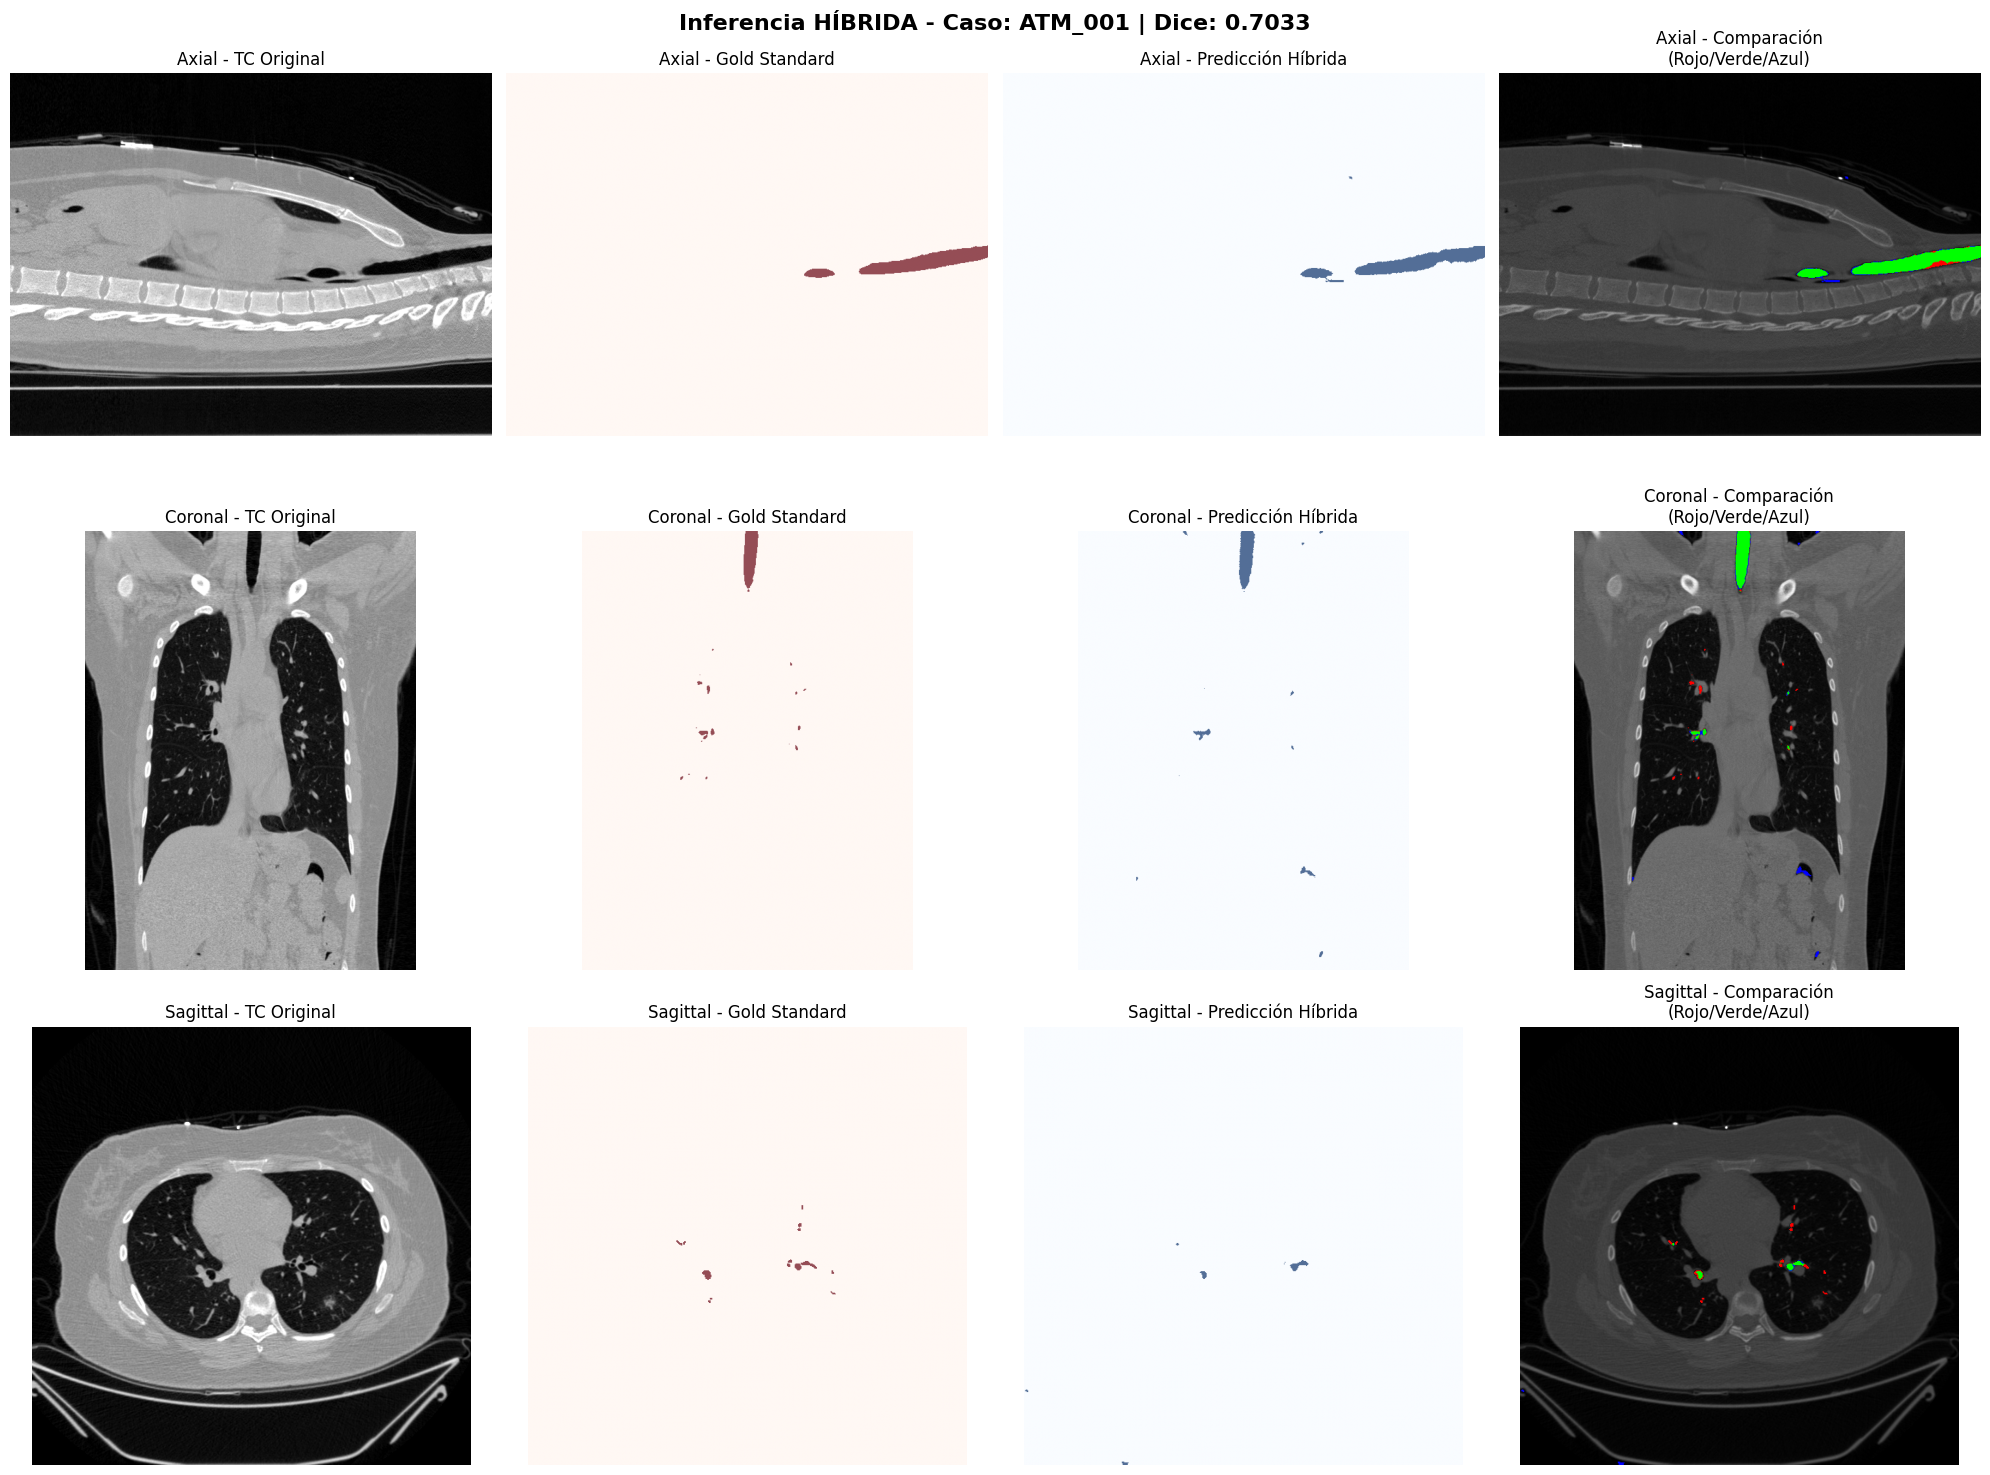


Predicción híbrida guardada en: ./results\ATM_001_hybrid_prediction.nii.gz
Figura de comparación guardada en: ./results/hybrid_comparison_ATM_001.png


In [76]:
# ---------------------------------------------------------------
# Cell 4: Visualización y comparación de resultados
# Compara la predicción híbrida con el gold standard manual
# ---------------------------------------------------------------

import matplotlib.pyplot as plt
import numpy as np

# === PARÁMETROS DE VISUALIZACIÓN ===
z_mid = inference_vol_orig.shape[0] // 2
y_mid = inference_vol_orig.shape[1] // 2
x_mid = inference_vol_orig.shape[2] // 2

# === EXTRACCIÓN DE CORTES ===
# Axial
axial_ct = inference_vol_orig[z_mid, :, :]
axial_manual = inference_vol_label[z_mid, :, :]
axial_pred = inference_pred_binary[z_mid, :, :]

# Coronal
coronal_ct = np.rot90(inference_vol_orig[:, y_mid, :], k=1)
coronal_manual = np.rot90(inference_vol_label[:, y_mid, :], k=1)
coronal_pred = np.rot90(inference_pred_binary[:, y_mid, :], k=1)

# Sagittal
sagittal_ct = np.rot90(inference_vol_orig[:, :, x_mid], k=-1)
sagittal_manual = np.rot90(inference_vol_label[:, :, x_mid], k=-1)
sagittal_pred = np.rot90(inference_pred_binary[:, :, x_mid], k=-1)

# === CREACIÓN DE LA FIGURA ===
fig, axes = plt.subplots(3, 4, figsize=(20, 15))
fig.suptitle(f"Inferencia HÍBRIDA - Caso: {inference_case_id} | Dice: {inference_dice_score:.4f}", 
             fontsize=16, fontweight='bold')

# === AXIAL ===
axes[0, 0].imshow(axial_ct, cmap='gray', vmin=-1024, vmax=600)
axes[0, 0].set_title("Axial - TC Original", fontsize=12)
axes[0, 0].axis("off")

axes[0, 1].imshow(axial_manual, cmap='Reds', alpha=0.7)
axes[0, 1].set_title("Axial - Gold Standard", fontsize=12)
axes[0, 1].axis("off")

axes[0, 2].imshow(axial_pred, cmap='Blues', alpha=0.7)
axes[0, 2].set_title("Axial - Predicción Híbrida", fontsize=12)
axes[0, 2].axis("off")

# Superposición axial
overlay_axial = np.copy(axial_ct)
overlay_axial = (overlay_axial - overlay_axial.min()) / (overlay_axial.max() - overlay_axial.min() + 1e-8)
rgb_overlay = np.stack([overlay_axial, overlay_axial, overlay_axial], axis=-1)
rgb_overlay[(axial_manual > 0) & (axial_pred == 0)] = [1, 0, 0]  # Rojo: solo manual
rgb_overlay[(axial_manual == 0) & (axial_pred > 0)] = [0, 0, 1]  # Azul: solo predicción
rgb_overlay[(axial_manual > 0) & (axial_pred > 0)] = [0, 1, 0]   # Verde: intersección

axes[0, 3].imshow(rgb_overlay)
axes[0, 3].set_title("Axial - Comparación\n(Rojo/Verde/Azul)", fontsize=12)
axes[0, 3].axis("off")

# === CORONAL ===
axes[1, 0].imshow(coronal_ct, cmap='gray', vmin=-1024, vmax=600)
axes[1, 0].set_title("Coronal - TC Original", fontsize=12)
axes[1, 0].axis("off")

axes[1, 1].imshow(coronal_manual, cmap='Reds', alpha=0.7)
axes[1, 1].set_title("Coronal - Gold Standard", fontsize=12)
axes[1, 1].axis("off")

axes[1, 2].imshow(coronal_pred, cmap='Blues', alpha=0.7)
axes[1, 2].set_title("Coronal - Predicción Híbrida", fontsize=12)
axes[1, 2].axis("off")

# Superposición coronal
overlay_coronal = np.copy(coronal_ct)
overlay_coronal = (overlay_coronal - overlay_coronal.min()) / (overlay_coronal.max() - overlay_coronal.min() + 1e-8)
rgb_overlay_cor = np.stack([overlay_coronal, overlay_coronal, overlay_coronal], axis=-1)
rgb_overlay_cor[(coronal_manual > 0) & (coronal_pred == 0)] = [1, 0, 0]
rgb_overlay_cor[(coronal_manual == 0) & (coronal_pred > 0)] = [0, 0, 1]
rgb_overlay_cor[(coronal_manual > 0) & (coronal_pred > 0)] = [0, 1, 0]

axes[1, 3].imshow(rgb_overlay_cor)
axes[1, 3].set_title("Coronal - Comparación\n(Rojo/Verde/Azul)", fontsize=12)
axes[1, 3].axis("off")

# === SAGITTAL ===
axes[2, 0].imshow(sagittal_ct, cmap='gray', vmin=-1024, vmax=600)
axes[2, 0].set_title("Sagittal - TC Original", fontsize=12)
axes[2, 0].axis("off")

axes[2, 1].imshow(sagittal_manual, cmap='Reds', alpha=0.7)
axes[2, 1].set_title("Sagittal - Gold Standard", fontsize=12)
axes[2, 1].axis("off")

axes[2, 2].imshow(sagittal_pred, cmap='Blues', alpha=0.7)
axes[2, 2].set_title("Sagittal - Predicción Híbrida", fontsize=12)
axes[2, 2].axis("off")

# Superposición sagittal
overlay_sagittal = np.copy(sagittal_ct)
overlay_sagittal = (overlay_sagittal - overlay_sagittal.min()) / (overlay_sagittal.max() - overlay_sagittal.min() + 1e-8)
rgb_overlay_sag = np.stack([overlay_sagittal, overlay_sagittal, overlay_sagittal], axis=-1)
rgb_overlay_sag[(sagittal_manual > 0) & (sagittal_pred == 0)] = [1, 0, 0]
rgb_overlay_sag[(sagittal_manual == 0) & (sagittal_pred > 0)] = [0, 0, 1]
rgb_overlay_sag[(sagittal_manual > 0) & (sagittal_pred > 0)] = [0, 1, 0]

axes[2, 3].imshow(rgb_overlay_sag)
axes[2, 3].set_title("Sagittal - Comparación\n(Rojo/Verde/Azul)", fontsize=12)
axes[2, 3].axis("off")

plt.tight_layout()
plt.savefig(os.path.join("./results", f"hybrid_comparison_{inference_case_id}.png"), 
            dpi=300, bbox_inches='tight')
plt.show()

# === GUARDADO DEL RESULTADO ===
output_path = os.path.join("./results", f"{inference_case_id}_hybrid_prediction.nii.gz")
nib.save(nib.Nifti1Image(inference_pred_binary.astype(np.uint8), inference_affine, inference_header), output_path)
print(f"\nPredicción híbrida guardada en: {output_path}")
print(f"Figura de comparación guardada en: ./results/hybrid_comparison_{inference_case_id}.png")